In [288]:
import glob
from astropy import table
from astropy.io import ascii
import copy
import numpy as np
import matplotlib.pyplot as plt
import	multiprocessing as mp
#from plotsettings_py36 import *
from scipy import interpolate
import scipy
import scipy.optimize
from scipy.optimize import curve_fit
import time
import pandas as pd 
from scipy import stats
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import time
import statistics 

##### Measuring how long it takes

In [289]:
start = time.time()

# (Super) Functions

In [290]:
def cartesian_product(*arrays):
    la = len(arrays)
    dtype = np.result_type(*arrays)
    arr = np.empty([len(a) for a in arrays] + [la], dtype=dtype)
    for i, a in enumerate(np.ix_(*arrays)):
        arr[...,i] = a
    return arr.reshape(-1, la)

In [291]:
#lam is in angtroms 
#A_v is a user input

import extinction

A_v = 1.0

def Alam(lamin, A_v):

    lam       = np.zeros(len(lamin))
    redreturn = np.zeros(len(lamin))

    #Add extinction with R_v= 3.1 and A_v = 1     
    extinction.ccm89(lam, A_v, 3.1)
        
    return redreturn


In [292]:
def select_templates(DATABASE, TYPES):

       
#    Selects templates of a given type(s) from a template database
    
#    Input: DATEBASE   list of templates
#           TYPES      which types should be selected
    
#    Output: array of templates of given type(s)
       
    database_trunc = list([])
    
    for type in TYPES:
        database_trunc += list([x for x in DATABASE if type in x])
    
    return np.array(database_trunc)

### Get Sigma

In [293]:
def error_spectra(spec_object): 

    flux = spec_object[:,1]
    lam  = spec_object[:,0]

#For how many points do we make the lines
    num=10

    if len(flux)%num != 0:
        c = len(flux)%num
        flux = flux[:-c]
        lams = lam[:-c]
    
    else:
        lams = lam
        c = 0
    
    
    flux_new = flux.reshape((-1, num))
    lam_new  = lams.reshape((-1, num))
    m = []
    b = []
    sigma = []

    for n in range(len(lam_new)):
        r=[]
        error=[]
        
        a = np.polyfit(lam_new[n], flux_new[n], 1)
        m.append(a[0])
        b.append(a[1])
        y = m[n]*lam_new[n]+b[n]
          
        r = flux_new - y
        
        plt.plot(lam_new[n], flux_new[n], '.' )
        plt.plot(lam_new[n], y)
        plt.plot(lam_new[n], flux_new[n]-y, 'ko', markersize=1)
       
        plt.title('For n*10th Entry')
        plt.ylabel('Flux')
        plt.xlabel('Lamda')
    

    for i in r: 
        s = statistics.stdev(i)
        sigma.append(s)
    

# Here we make the error be the same size as the original lambda and then take the transpose

    error = list(np.repeat(sigma, num))
    l = [error[-1]] * c
    error = error + l

    error = np.asarray(error)
    
    return np.array([lam,error]).T

# Compute the (Super) fit

In [294]:
def wrapper_fit(DATABASE):

    """
    Compute the fit
    """
   
    # 1) File i/o
    
    spec_gal    =  np.loadtxt(DATABASE['GALAXY'])
    spec_SN     =  np.loadtxt(DATABASE['SN'])
    spec_object =  np.loadtxt(DATABASE['OBJECT'])
    error       =  error_spectra(spec_object)

    
    
    spec_gal_interp        =  interpolate.interp1d(spec_gal[:,0],    spec_gal[:,1],    bounds_error=False, fill_value=0)
    spec_sn_interp         =  interpolate.interp1d(spec_SN[:,0],     spec_SN[:,1],     bounds_error=False, fill_value=0)
    spec_object_interp     =  interpolate.interp1d(spec_object[:,0], spec_object[:,1], bounds_error=False, fill_value=0)
    spec_object_err_interp =  interpolate.interp1d(error[:,0],       error[:,1],       bounds_error=False, fill_value=np.inf)
               

    

    #def func(x, b, d):
    #    return b * spec_sn_interp(x)*10**(float(DATABASE['DUST']) * Alam(x,1)) + d * spec_gal_interp(x)    

    
    
    number = 300
    z = np.random.randint(0,400,number)/1000.
    #z = np.linspace(0, 1, 0.01)
    
    
    for i in range(len(z)):
          
        
        #temp_spec_object = copy.deepcopy(spec_object)
        #temp_spec_object[:,0] /= (z[i] + 1)
            
    
        lambda_min   =   max([   spec_gal[:,0][0],  spec_SN[:,0][0],  spec_object[:,0][0]   ])
        lambda_max   =   min([   spec_gal[:,0][-1], spec_SN[:,0][-1], spec_object[:,0][-1]  ])
        lambda_new   =   spec_object[:,0][ (spec_object[:,0] >= lambda_min) & (spec_object[:,0] <= lambda_max) ]
    
    
        
        sigma        =  spec_object_err_interp(lambda_new)
        object_spec  =  spec_object_interp    (lambda_new)

        
        def func(x, b, d):
            return b * spec_sn_interp(x)*10**(float(DATABASE['DUST']) * Alam(x,1)) + d * spec_gal_interp(x)    

        
        result = curve_fit(func, lambda_new/(z[i] + 1), object_spec, sigma=sigma, p0=[0,0])
        
        popt   = result[0]
        pcov   = result[1]
        
        #Regular chi2
        chi2   =  np.sum(((object_spec - func(lambda_new, *popt))/sigma)**2)
        
        #Reduced chi2
        chi2   =  chi2/(len(lambda_new) - 4)

    output=table.Table(
                        np.array([DATABASE['OBJECT'], DATABASE['GALAXY'], DATABASE['SN'],popt[0],popt[1],z[i],chi2,float(DATABASE['DUST'])]), 
                        names=('OBJECT', 'GALAXY', 'SN', 'CONST_SN','CONST_GAL','CONST_Z','CHI2','DUST'), 
                        dtype=('S100', 'S100', 'S100','f','f','f','f','f'))
            
         
    output        
            
   
    return output
    

# Read in spectral database

In [295]:

templates_gal = glob.glob('rebinned/gal/*')
templates_gal = [x for x in templates_gal if 'CVS' not in x and 'README' not in x]
templates_gal = np.array(templates_gal)



#templates_sn = glob.glob('rebinned/small/Ib/*')
templates_sn = glob.glob('rebinned/sne/**/*')
templates_sn = [x for x in templates_sn if 'CVS' not in x and 'README' not in x]
templates_sn = np.array(templates_sn)



#The beginning, end, and interval for the dust are decided by the user  

templates_dust = np.array([-0.2, 0, 0.1])


## Truncate templates SN, HG


In [296]:
# The user decides how to truncate the supernova and host galaxy templates


#templates_sn_trunc = select_templates(templates_sn, ['/II/'])
templates_sn_trunc = select_templates(templates_sn, ['/II/'])



#templates_gal_trunc = select_templates(templates_gal, ['/E', '/S0', '/Sa','/SB1','/SB2','/SB3','/SB4','/SB5','/SB6'])
templates_gal_trunc = select_templates(templates_gal, ['/SB4'])


# Compute the cartesian product of SN templates, galaxy templates and extinction measurements

In [297]:
cartesian_product_all  =  cartesian_product(*[templates_gal_trunc[:1], templates_sn_trunc, templates_dust])
cartesian_product_all  =  table.Table(cartesian_product_all, names=('GALAXY', 'SN', 'DUST'))


# Here the user enters the template he wants to analize 
cartesian_product_all['OBJECT']=["/home/sam/Dropbox/superfit/rebinned/combined/avishay"]


cartesian_product_all

GALAXY,SN,DUST,OBJECT
str34,str34,str34,str52
rebinned/gal/SB4,rebinned/sne/II/sn2005cs.p33.dat,-0.2,/home/sam/Dropbox/superfit/rebinned/combined/avishay
rebinned/gal/SB4,rebinned/sne/II/sn2005cs.p33.dat,0.0,/home/sam/Dropbox/superfit/rebinned/combined/avishay
rebinned/gal/SB4,rebinned/sne/II/sn2005cs.p33.dat,0.1,/home/sam/Dropbox/superfit/rebinned/combined/avishay
rebinned/gal/SB4,rebinned/sne/II/sn2004et.p169.dat,-0.2,/home/sam/Dropbox/superfit/rebinned/combined/avishay
rebinned/gal/SB4,rebinned/sne/II/sn2004et.p169.dat,0.0,/home/sam/Dropbox/superfit/rebinned/combined/avishay
rebinned/gal/SB4,rebinned/sne/II/sn2004et.p169.dat,0.1,/home/sam/Dropbox/superfit/rebinned/combined/avishay
rebinned/gal/SB4,rebinned/sne/II/sn1993j.p23.dat,-0.2,/home/sam/Dropbox/superfit/rebinned/combined/avishay
rebinned/gal/SB4,rebinned/sne/II/sn1993j.p23.dat,0.0,/home/sam/Dropbox/superfit/rebinned/combined/avishay
rebinned/gal/SB4,rebinned/sne/II/sn1993j.p23.dat,0.1,/home/sam/Dropbox/superfit/rebinned/combined/avishay


In [298]:
index_array=range(len(cartesian_product_all))
index_array

range(0, 288)

In [299]:
%%capture
output=wrapper_fit(cartesian_product_all[0])
output

In [300]:
%%capture

if mp.cpu_count() > 1:
     number_cpu	= mp.cpu_count()/2	# is equal to number of threads x number of physical cpus, e.g. 2x4
else:
    number_cpu	= mp.cpu_count()
number_cpu
pool	= mp.Pool(processes=int(number_cpu)*2)


In [301]:
result = pool.map(wrapper_fit, cartesian_product_all)

In [302]:
result=table.vstack(result)

In [303]:
#%%capture
#result=[wrapper_fit(x) for x in cartesian_product_all]
#result=table.vstack(result)

In [304]:
result
result.sort('CHI2')
result

OBJECT,GALAXY,SN,CONST_SN,CONST_GAL,CONST_Z,CHI2,DUST
bytes100,bytes100,bytes100,float32,float32,float32,float32,float32
/home/sam/Dropbox/superfit/rebinned/combined/avishay,rebinned/gal/SB4,rebinned/sne/II/sn1980K.p41.dat,0.49974,-0.02124054,0.039,5.8793244,-0.2
/home/sam/Dropbox/superfit/rebinned/combined/avishay,rebinned/gal/SB4,rebinned/sne/II/sn2002bj.p02.dat,-1.2971798,2.157149,0.005,6.601563,0.1
/home/sam/Dropbox/superfit/rebinned/combined/avishay,rebinned/gal/SB4,rebinned/sne/II/sn1979C.p07.dat,-1.4710575,2.1106162,0.005,8.611195,0.1
/home/sam/Dropbox/superfit/rebinned/combined/avishay,rebinned/gal/SB4,rebinned/sne/II/sn1980K.p41.dat,0.52334297,0.04559,0.119,10.079499,0.0
/home/sam/Dropbox/superfit/rebinned/combined/avishay,rebinned/gal/SB4,rebinned/sne/II/sn2004et.p76.dat,0.8860835,-0.0288312,0.009,10.140222,0.0
/home/sam/Dropbox/superfit/rebinned/combined/avishay,rebinned/gal/SB4,rebinned/sne/II/sn2005cs.p06.dat,-0.7735524,1.9419613,0.021,11.06983,-0.2
/home/sam/Dropbox/superfit/rebinned/combined/avishay,rebinned/gal/SB4,rebinned/sne/II/sn2004et.p106.dat,0.6511426,0.0914779,0.021,12.960075,0.0
/home/sam/Dropbox/superfit/rebinned/combined/avishay,rebinned/gal/SB4,rebinned/sne/II/sn1988A.p03.dat,-0.35550934,0.7233949,0.019,14.279423,0.0
/home/sam/Dropbox/superfit/rebinned/combined/avishay,rebinned/gal/SB4,rebinned/sne/II/sn2005db.p40.dat,3.130577,-2.1457565,0.021,14.860057,0.0


# (Super) Graph

In [305]:
def visualise_match(DATABASE):

 
    spec_gal    =   np.loadtxt(DATABASE['GALAXY'][0])
    spec_SN     =   np.loadtxt(DATABASE['SN'][0])
    spec_object =   np.loadtxt(DATABASE['OBJECT'][0])
    #spec_object[:,1]*=10

    spec_gal[:,0] *= (1+DATABASE['CONST_Z'])
    spec_SN [:,0] *= (1+DATABASE['CONST_Z'])
    
#Plot data

    lambda_min = max([spec_gal[:,0][0],  spec_SN[:,0][0]])
    lambda_max = min([spec_gal[:,0][-1], spec_SN[:,0][-1]])
    
    lam = spec_SN[:,0][ (spec_SN[:,0] >= lambda_min) & (spec_SN[:,0] <= lambda_max) ]
    
    spec_gal_interp  = interpolate.interp1d(spec_gal[:,0], DATABASE['CONST_GAL']*spec_gal[:,1], bounds_error=False, fill_value=np.nan)
    
    spec_sn_interp  = interpolate.interp1d(spec_SN[:,0], 
                                           DATABASE['CONST_SN']  *spec_SN[:,1]*10**(float(DATABASE['DUST']) * Alam(spec_SN[:,0],1)),
                                           bounds_error=False, fill_value=np.nan)
    
    #combined = spec_gal_interp(lam*(DATABASE['CONST_Z'] + 1 )) + spec_sn_interp(lam*(DATABASE['CONST_Z'] +1 ))
    
    combined = spec_gal_interp(lam) + spec_sn_interp(lam)



    plt.figure(figsize=(7*np.sqrt(2), 7))
    
    ax = plt.subplot(111)
    ax.plot(spec_object[:,0], spec_object[:,1], 'm' , lw=5, label='Input spectrum')    
    #ax.plot(spec_gal[:,0], DATABASE['CONST_GAL'] * spec_gal[:,1], lw=1, label='Galaxy template')#: {}'.format(bestfit_galaxy))
    #ax.plot(spec_SN[:,0],  DATABASE['CONST_SN']  * spec_SN[:,1] ,  lw=3, label='SN template')#: {name} ({type}, {phase} days)'.format(type=bestfit_sn_type, name=bestfit_sn_name, phase=bestfit_sn_phase))
    ax.plot(lam, combined, 'k' ,lw=2, label='Combined template')


    
    ax.legend()#fontsize=legend_size-4)
    
    ax.set_xlabel('Observed wavelength (\\AA)')
    ax.set_ylabel('Flux density (arbitary units)')
    
    ax.set_xlim(spec_object[0,0]-20, spec_object[-1,0]-20)
    ax.set_ylim(0, max(spec_object[:,1])*1.2)
    
    plt.show()


<Table length=1>
   name    dtype  
--------- --------
   OBJECT bytes100
   GALAXY bytes100
       SN bytes100
 CONST_SN  float32
CONST_GAL  float32
  CONST_Z  float32
     CHI2  float32
     DUST  float32
None


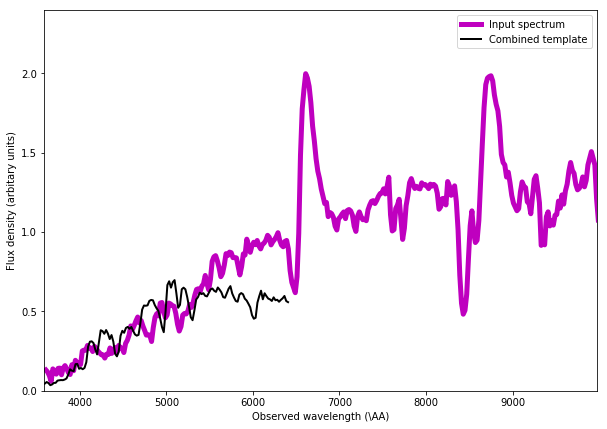

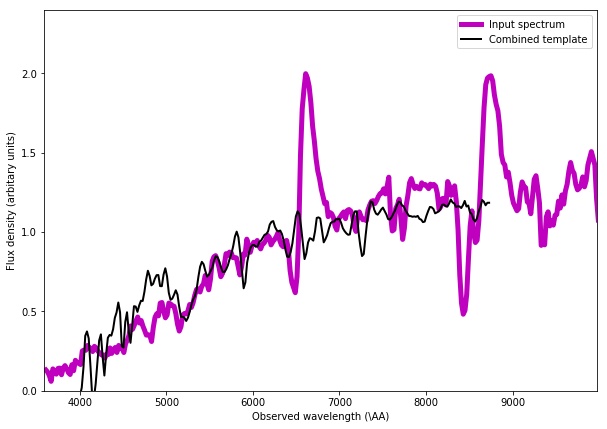

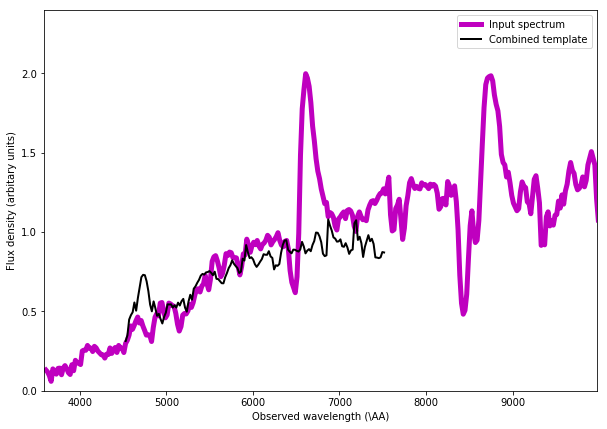

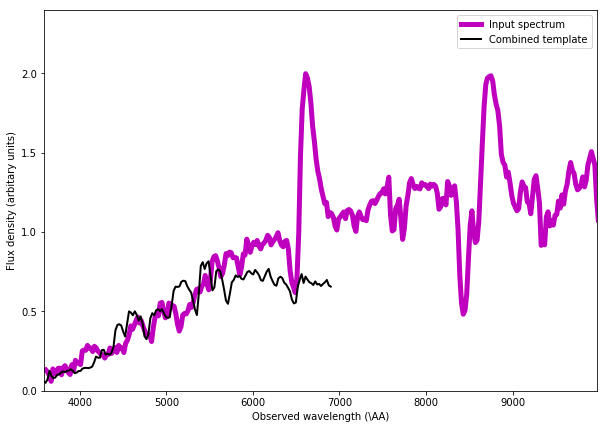

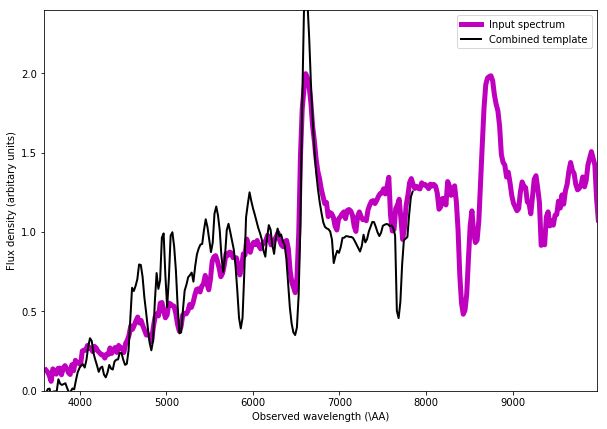

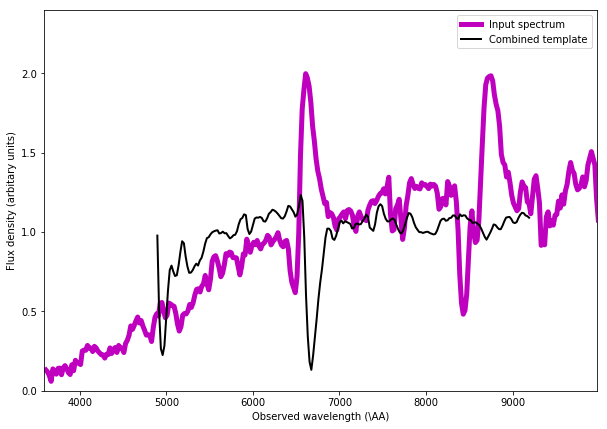

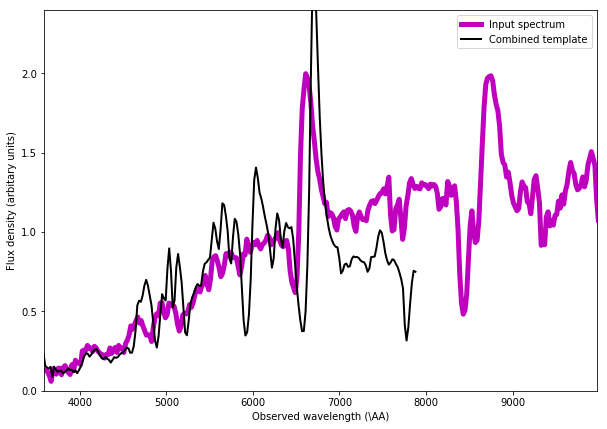

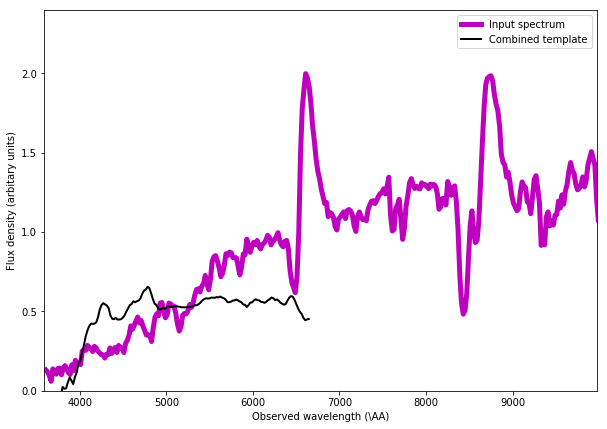

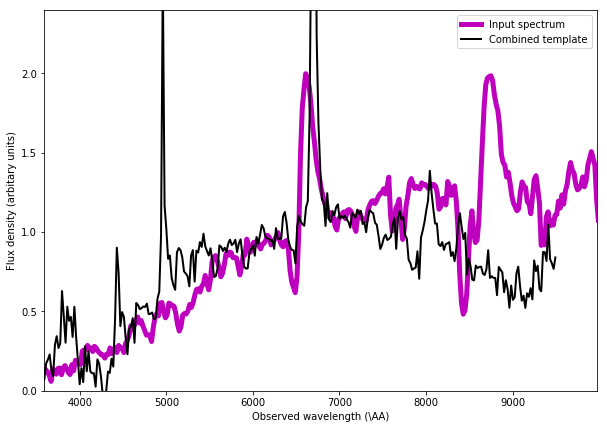

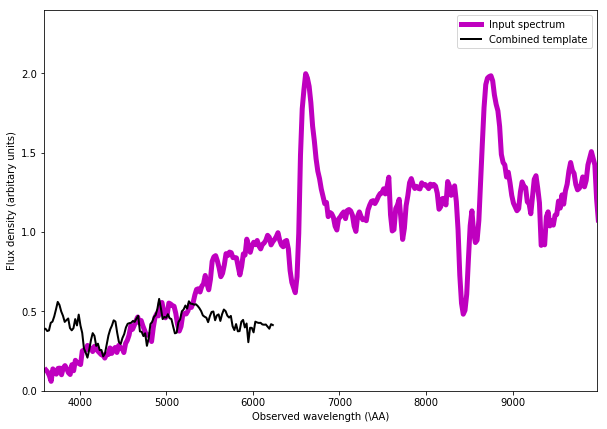

In [319]:
print(output.info())

b = [0,1,2,3,4,5,6,7,8,9]

for i in b:
    visualise_match(table.Table(result[i]))

##### This took:

In [307]:
end = time.time()
print(end - start, 'seconds')

19.852160930633545 seconds


In [308]:
table.Table(result[0])

OBJECT,GALAXY,SN,CONST_SN,CONST_GAL,CONST_Z,CHI2,DUST
bytes100,bytes100,bytes100,float32,float32,float32,float32,float32
/home/sam/Dropbox/superfit/rebinned/combined/avishay,rebinned/gal/SB4,rebinned/sne/II/sn1980K.p41.dat,0.49974,-0.02124054,0.039,5.8793244,-0.2
